# Проект по А/B-тестированию

## Описание проекта

Необходимо провести оценку результатов A/B-теста:
- оценить корректность проведения теста;
- проанализировать результаты теста.

В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

Техническое задание:
- Название теста: recommender_system_test;
- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
  1. конверсии в просмотр карточек товаров — событие product_page
  - просмотры корзины — product_cart
  - покупки — purchase.

## <a name="0"> Структура проекта </a>

- [Загрузка данных и ознакомление с ними](#1)
- [Предобработка данных](#2)
- [Очистка данных](#3)
- [Анализ результатов A/B теста](#4)
- [Общие выводы](#5)

## <a name="1"> Загрузка данных и ознакомление с ними </a>

Загрузим необходимые библиотеки для работы с таблицами, проверки статистических гипотез и визуализации:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.simplefilter('ignore')

Загрузим таблицу `ab_project_marketing_events` и посмотрим на данные:

In [2]:
ab_project_marketing_events = pd.read_csv('/Users/polzovatel/Desktop/Projects/Recommendation_system_ab_test/ab_project_marketing_events.csv')
ab_project_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


В этой таблице находится календарь маркетинговых событий на 2020 год.

Структура таблицы:
- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

In [3]:
ab_project_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


В таблице 14 строк - по строке на каждое маркетинговое событие. Пропусков в значениях нет.

Загрузим таблицу `final_ab_new_users` и посмотрим на данные:

In [4]:
final_ab_new_users = pd.read_csv('/Users/polzovatel/Desktop/Projects/Recommendation_system_ab_test/final_ab_new_users.csv')
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


В этой таблице находится информация о пользователях, зарегистрировавшихся с 7 по 21 декабря 2020 года.

Структура таблицы:
- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

In [5]:
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


В таблице 61 733 строки - по строке на каждого пользователя. Пропусков в значениях нет.

Загрузим таблицу `final_ab_events` и посмотрим на данные:

In [6]:
final_ab_events = pd.read_csv('/Users/polzovatel/Desktop/Projects/Recommendation_system_ab_test/final_ab_events.csv')
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


В этой таблице находится информация о действиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура таблицы:
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase`, в этом поле хранится стоимость покупки в долларах.

In [7]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


В таблице 440 317 строк - по строке на каждое событие. Есть пропуски в столбце `details`. Надо проверить, что эти пропуски относятся не к событиям `purchase`, для которых должна быть указана стоимость покупки. Сделаем это на этапе предобработки данных.

Загрузим таблицу `final_ab_participants` и посмотрим на данные:

In [8]:
final_ab_participants = pd.read_csv('/Users/polzovatel/Desktop/Projects/Recommendation_system_ab_test/final_ab_participants.csv')
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


В этой таблице находится информация об участниках тестов.

Структура таблицы:
- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

In [9]:
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


В таблице 18 268 строк - по строке на каждого участника теста. Пропусков в значениях нет.

Теперь проверим дубли в таблицах, оценим пропуски и изменим тип данных, где это требуется.

[К началу](#0)

## <a name="2"> Предобработка данных </a>

Проверим таблицы на наличие строк-дублей:

In [10]:
ab_project_marketing_events.duplicated().sum()\
, final_ab_new_users.duplicated().sum()\
, final_ab_events.duplicated().sum()\
, final_ab_participants.duplicated().sum()

(0, 0, 0, 0)

Дублей нет.

Проверим пропуски в таблице `final_ab_events`: узнаем, у каких событий есть пропущенные значения в столбце `details`:

In [11]:
final_ab_events.query('details.isnull()')['event_name'].unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

Пропуски встречаются для трёх типов событий. Проверим, что данные заполнены только среди событий `purchase`:

In [12]:
final_ab_events.query('details.notnull()')['event_name'].unique()

array(['purchase'], dtype=object)

Всё в рамках логики. Какую-то обработку пропусков делать не нужно.

Теперь приведём все столбцы, в которых хранятся даты и время, к типу datetime:

In [13]:
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])

Проверим, что типы данных преобразовались:

In [14]:
ab_project_marketing_events['start_dt'].dtype\
, ab_project_marketing_events['finish_dt'].dtype\
, final_ab_new_users['first_date'].dtype\
, final_ab_events['event_dt'].dtype

(dtype('<M8[ns]'), dtype('<M8[ns]'), dtype('<M8[ns]'), dtype('<M8[ns]'))

Данные предобработаны, теперь с таблицами можно работать. Изучим их и оставим только необходимую для анализа результатов нашего A/B-теста информацию.

[К началу](#0)

## <a name="3"> Очистка данных </a>

Из технического задания нам известно, что A/B-тест проводился с 7 декабря 2020 по 4 января 2021 года. Выберем все маркетинговые активности, которые действовали в этот период:

In [15]:
ab_project_marketing_events.query('finish_dt >= "2020-12-07"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Проводились 2 активности. Причем одна из них проводилась в регионе CIS, а нас интересует только EU, поэтому не будем её учитывать. Запомним, что в интересующем нас регионе была запущена активность `Christmas&New Year Promo` 25 декабря.

Теперь посмотрим, в какие конкурирующие тесты попали участники тестов:

In [16]:
final_ab_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Помимо нашего теста `recommender_system_test` пользователи приняли участие в `interface_eu_test`. В нашем тесте проверяются изменения, связанные с внедрением улучшенной рекомендательной системы. А судя по названию конкурирующего теста, в нём оцениваются изменения в интерфейсе. 

Узнаем, сколько пользователей всего приняли участие в тестах - нашем и конкурирующем:

In [17]:
final_ab_participants['user_id'].nunique()

16666

Узнаем, сколько из них приняли участие в обоих тестах:

In [18]:
temp = final_ab_participants.groupby('user_id')['ab_test'].count().reset_index()
len(temp.query('ab_test > 1'))

1602

В A/B-тестах приняли участие 16 666 пользователей, из них 1602 - сразу в двух тестах. Чтобы исключить влияние изменений в тесте `interface_eu_test` на оценку результатов в тесте `recommender_system_test`, выберем тех пользователей, которые приняли участие в только в нашем тесте:

In [19]:
wrong_users = final_ab_participants.query('ab_test == "interface_eu_test"')['user_id'].unique()
ab_participants = final_ab_participants.query('user_id not in @wrong_users')
ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
5,4FF2998A348C484F,A,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test


Посчитаем, сколько таких пользователей:

In [20]:
len(ab_participants)

5099

Сделаем проверку, что пользователи не задвоились и не пропали. Посчитаем, сколько пользователей приняли участие в тесте `interface_eu_test`:

In [21]:
final_ab_participants.query('ab_test == "interface_eu_test"')['user_id'].nunique()

11567

Цифры сходятся: из 16 666 участников тестов 5099 приняли участие только в `recommender_system_test`, 11 567, то есть оставшиеся, приняли участие в `interface_eu_test`, из которых 1602 приняли участие в обоих тестах.

Теперь отобранным участникам нашего теста добавим данные о регионах и девайсах:

In [22]:
new_ab_participants = final_ab_new_users.merge(ab_participants, on='user_id', how='right')
new_ab_participants.head()

,user_id,first_date,region,device,group,ab_test
0,D1ABA3E2887B6A73,2020-12-07,EU,PC,A,recommender_system_test
1,A7A3664BD6242119,2020-12-20,EU,iPhone,A,recommender_system_test
2,482F14783456D21B,2020-12-14,EU,PC,B,recommender_system_test
3,4FF2998A348C484F,2020-12-20,EU,Mac,A,recommender_system_test
4,7473E0943673C09E,2020-12-16,EU,iPhone,A,recommender_system_test


Проверим, что для каждого пользователя нашлась эта информация:

In [23]:
new_ab_participants.isnull().sum()

user_id       0
first_date    0
region        0
device        0
group         0
ab_test       0
dtype: int64

Отлично, пропусков нет.

Посмотрим на регионы пользователей:

In [24]:
new_ab_participants['region'].value_counts()

EU           4749
N.America     223
APAC           72
CIS            55
Name: region, dtype: int64

Из ТЗ известно, что аудиторией нашего теста являются пользователи из региона EU - их оказалось 4749 человек. Очистим данные от пользователей из других регионов: 

In [25]:
new_ab_participants = new_ab_participants.query('region == "EU"')

Проверим, что все пользователи зарегистрировались с 7 по 21 декабря 2020 года:

In [26]:
new_ab_participants[['first_date']].describe().T

,count,unique,top,freq,first,last
first_date,4749,15,2020-12-21,504,2020-12-07,2020-12-21


Теперь в таблице остались только пользователи из `EU`, которые зарегистрировались с 7 по 21 декабря 2020 года и не принимали участие в конкурирующих тестах. Объединим получившуюся таблицу с таблицей с действиями пользователей по `user_id`:

In [27]:
ab_participants_events = new_ab_participants.merge(final_ab_events, on='user_id', how='left')
ab_participants_events.head()

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details
0,D1ABA3E2887B6A73,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,2020-12-07,EU,PC,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN
3,D1ABA3E2887B6A73,2020-12-07,EU,PC,A,recommender_system_test,2020-12-25 00:04:57,product_cart,NaN
4,D1ABA3E2887B6A73,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN


Посчитаем количество действий:

In [28]:
len(ab_participants_events)

19681

... и количество участников теста, совершивших хотя бы одно действие:

In [29]:
ab_participants_events.query('event_name.notnull()')['user_id'].nunique()

2594

Только 2594 участников из 4749 совершили хотя бы одно действие.

Проверим, что действия пользователей совершены с 7 декабря 2020 по 4 января 2021 года:

In [30]:
ab_participants_events[['event_dt']].describe().T

,count,unique,top,freq,first,last
event_dt,17526,11709,2020-12-18 18:44:29,5,2020-12-07 00:16:00,2020-12-30 06:42:52


Участники совершали действия только до 30 декабря. Возможно после этого что-то сломалось в логировании, либо тест прекратили из-за надвигающегося нового года.

[К началу](#0)

## <a name="4"> Анализ результатов A/B теста </a>

Посмотрим, как пользователи разделились по группам:

In [31]:
groups_amount = ab_participants_events.groupby('group')['user_id'].nunique()
groups_amount

group
A    2713
B    2036
Name: user_id, dtype: int64

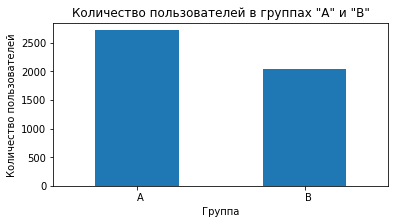

In [32]:
plt.figure(figsize=(6, 3))
ab_participants_events.groupby('group')['user_id'].nunique().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=0, ha='left')
plt.title('Количество пользователей в группах "A" и "B"')
plt.ylabel("Количество пользователей")
plt.xlabel("Группа")
plt.show()

Группа "A" оказалась примерно на треть больше группы "B". Посмотрим, на группы в разрезе девайсов:

In [33]:
ab_participants_events.groupby(['device', 'group'])['user_id'].nunique()

device   group
Android  A        1186
         B         943
Mac      A         248
         B         175
PC       A         712
         B         488
iPhone   A         567
         B         430
Name: user_id, dtype: int64

По всем девайсам группа "B" меньше группы "A". Посмотрим, насколько меньше:

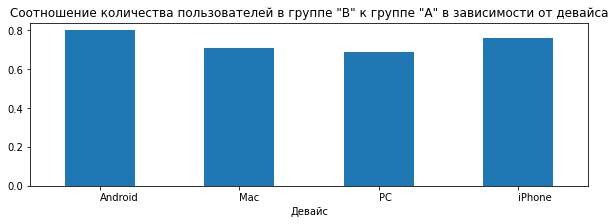

In [34]:
devices_and_groups = ab_participants_events.groupby(['device', 'group'])['user_id'].nunique()\
.reset_index()
for index in range(8):
    if index%2 == 0:
        devices_and_groups.loc[index, 'share_of_A'] = 1
    else:
        devices_and_groups.loc[index, 'share_of_A'] = round(devices_and_groups.loc[index, 'user_id'] /
        devices_and_groups.loc[index - 1, 'user_id'], 2)
plt.figure(figsize=(10, 3))
devices_and_groups.query('group == "B"').set_index('device')['share_of_A'].plot(kind='bar')
plt.xticks(rotation=0, ha='left')
plt.title('Соотношение количества пользователей в группе "B" к группе "A" в зависимости от девайса')
plt.xlabel("Девайс")
plt.show()

По всем девайсам соотношение количества пользователей в группе "B" к группе "A" примерно одинаковое и колеблется между 0,7 и 0,8. Для анализа теста это хорошо, потому что нет перекосов в разные стороны в размерах групп в разрезе девайсов. Это означает, что практически нет риска сделать ошибку, связанную с [парадоксом Симпсона](https://ru.wikipedia.org/wiki/%D0%9F%D0%B0%D1%80%D0%B0%D0%B4%D0%BE%D0%BA%D1%81_%D0%A1%D0%B8%D0%BC%D0%BF%D1%81%D0%BE%D0%BD%D0%B0), а значит мы можем оценивать результаты теста без разбивки по девайсам. Это облегчит анализ.

Посмотрим на распределение количества событий у пользователей в группах:

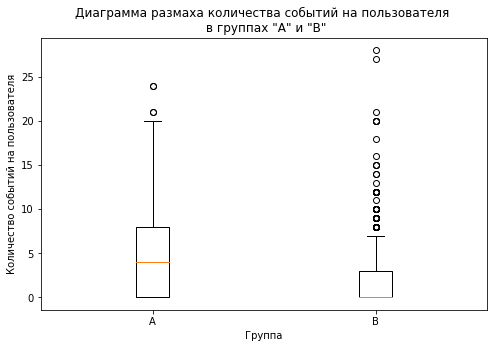

In [35]:
plt.figure(figsize=(8, 5))
plt.boxplot([ab_participants_events.query('group == "A"').groupby('user_id')['event_dt'].count()
             , ab_participants_events.query('group == "B"').groupby('user_id')['event_dt'].count()]
            , labels=['A', 'B'])
plt.title('Диаграмма размаха количества событий на пользователя \n в группах "A" и "B"')
plt.ylabel("Количество событий на пользователя")
plt.xlabel("Группа")
plt.show() 

В группе "B" ящик сплюснут у нуля и медиана там же. Пользователи в этой группе оказались неактивны по сравнению с группой "A". Это плохой знак, что тестовый вариант рекомендательной системы оказался сильно хуже.

Посмотрим, как число событий в разных группах распределено по дням:

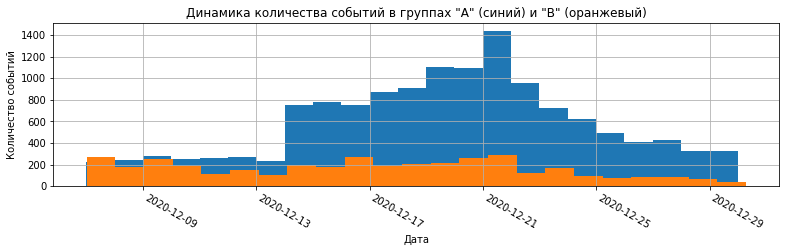

In [36]:
plt.figure(figsize=(13, 3))
ab_participants_events.query('group == "A"')['event_dt'].hist(bins=23)
ab_participants_events.query('group == "B"')['event_dt'].hist(bins=23)
plt.xticks(rotation=-30, ha='left')
plt.title('Динамика количества событий в группах "A" (синий) и "B" (оранжевый)')
plt.ylabel("Количество событий")
plt.xlabel("Дата")
plt.show()

На графике нет увеличения количества событий, начиная с 25 декабря, когда была запущена активность `Christmas&New Year Promo`. Поэтому мы не можем сказать, что она оказала какое-то влияние на тест. 

Также на графике хорошо видно, что начиная с 14 декабря группа "A" резко вырвалась по количеству событий. Возможно, в группу влилось много новых пользователей в этот день. Посмотрим, как группы наполнялись:

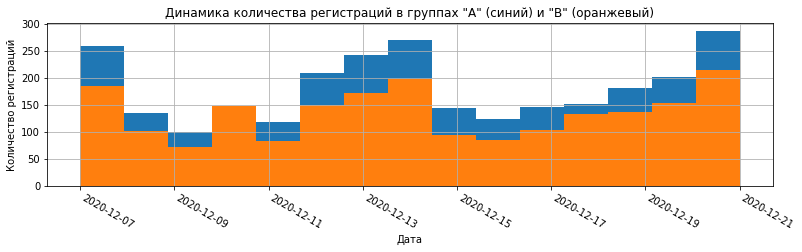

In [37]:
plt.figure(figsize=(13, 3))
ab_participants_events.groupby(['group', 'user_id'])['first_date'].min().reset_index()\
.query('group == "A"')['first_date'].hist(bins=15)
ab_participants_events.groupby(['group', 'user_id'])['first_date'].min().reset_index()\
.query('group == "B"')['first_date'].hist(bins=15)
plt.xticks(rotation=-30, ha='left')
plt.title('Динамика количества регистраций в группах "A" (синий) и "B" (оранжевый)')
plt.ylabel("Количество регистраций")
plt.xlabel("Дата")
plt.show()

Графики следуют почти эквидистантно, то есть нет моментов, чтобы одна группа резко пополнилась, а другая - нет. 

Построим воронку событий для групп:

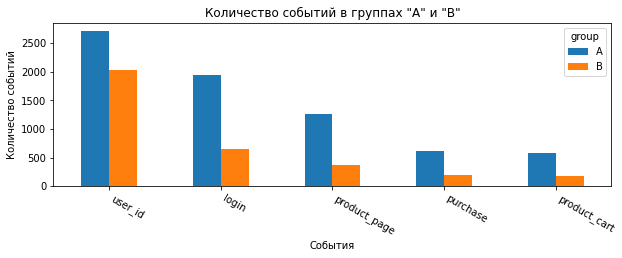

In [38]:
funnel = ab_participants_events.pivot_table(index=['group'], columns='event_name', values='user_id'
                                            , aggfunc='nunique').merge(groups_amount, on=['group'])
funnel.T.sort_values('A', ascending=False).plot(kind='bar', figsize=(10, 3))
plt.title('Количество событий в группах "A" и "B"')
plt.ylabel("Количество событий")
plt.xlabel("События")
plt.xticks(rotation=-30, ha='left')
plt.show()

События выстроились в следующую воронку: 
1. пользователь становится участником теста;
2. пользователь логинится;
3. пользователь заходит на страницу товара;
4. пользователь покупает товар;
5. пользователь заходит на страницу корзины.

Последнее событие немного выбивается из логики воронки. Следовало бы ожидать, что пользователь сначала заходит на страницу корзины, а потом уже покупает товар. Возможно, это связано с особенностями работы сайта. Всё же финальной точкой воронки будем считать факт покупки товара, поэтому заход на страницу корзины исключим из воронки.

Теперь рассчитаем конверсии при переходе с этапа на этап воронки:

In [39]:
funnel['cr_to_login'] = funnel['login'] / funnel['user_id']
funnel['cr_to_product_page'] = funnel['product_page'] / funnel['login']
funnel['cr_to_purchase'] = funnel['purchase'] / funnel['product_page']
funnel

,login,product_cart,product_page,purchase,user_id,cr_to_login,cr_to_product_page,cr_to_purchase
group,,,,,,,,
A,1939,589,1265,613,2713,0.714707,0.652398,0.484585
B,655,184,367,191,2036,0.321709,0.560305,0.520436


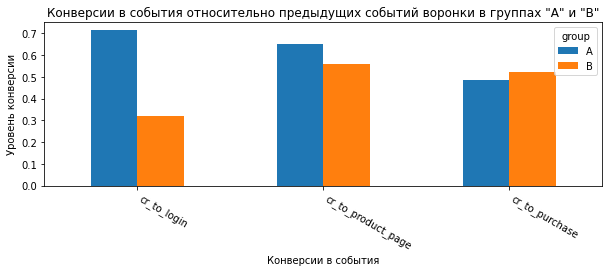

In [40]:
funnel.T.iloc[5:].sort_values('A', ascending=False).plot(kind='bar', figsize=(10, 3))
plt.title('Конверсии в события относительно предыдущих событий воронки в группах "A" и "B"')
plt.ylabel("Уровень конверсии")
plt.xlabel("Конверсии в события")
plt.xticks(rotation=-30, ha='left')
plt.show()

Группа "B" больше, чем в два раза проигрывает группе "A" по конверсии в залогинивания. Конверсия в переходы на страницу товара также хуже, но не так сильно. А вот конверсия в покупку оказалась даже немного выше.

Оценим конверсию участников теста в покупку:

In [41]:
funnel['total_cr'] = funnel['purchase'] / funnel['user_id']
funnel

,login,product_cart,product_page,purchase,user_id,cr_to_login,cr_to_product_page,cr_to_purchase,total_cr
group,,,,,,,,,
A,1939,589,1265,613,2713,0.714707,0.652398,0.484585,0.225949
B,655,184,367,191,2036,0.321709,0.560305,0.520436,0.093811


Конверсия участников из группы "A" составила 0,226, а из группы "B" - 0,094. 

Посчитаем статистическую значимость в различиях всех конверсий. Для этого нужно сделать три вещи:
- сформулировать нулевую и альтернативную гипотезу;
- выбрать статистический критерий, с помощью которого мы будем проверять гипотезы;
- принять критическое значение альфа, которое определяет границу между значимыми и незначимыми различиями.

Сформулируем гипотезы:

Нулевая гипотеза (H0): конверсии пользователей в покупки обеих групп относятся к общей генеральной совокупности с единой общей конверсией, а полученное различие является случайным.

Альтернативная гипотеза (H1): конверсии в группах относятся к разным генеральным совокупностям. Полученное различие вызвано тем, что они различаются в генеральных совокупностях.

Проверку различий в конверсиях разных групп проводят с помощью z-значения. Рассчитать его, а затем и p-value, можно, воспользовавшись функцией `proportions_ztest` библиотеки `statsmodels.stats.proportion`.

Критическим значением альфа обычно принимают 0,05. Такой уровень альфа позволяет нам рассчитывать, что примерно в 19 из 20 проверок не будет выявлено статистического различия при условии верности нулевой гипотезы. Вероятность ошибки - 5%.

Если проводить проверки нескольких гипотез, то вероятность совершить ошибку хотя бы раз будет увеличиваться: при проверке двух гипотез вероятность ошибки составит:

In [42]:
1 - (1 - .05)**2

0.09750000000000003

А при проверке 4-х гипотез:

In [43]:
1 - (1 - .05)**4

0.18549375000000012

Чтобы избежать ошибки, вводят поправку, например, поправку Бонферрони, при которой критическое значение альфа уменьшают в то количество раз, сколько проверок мы проводим. Поэтому, чтобы определить альфа, нужно посчитать, сколько проверок мы планируем сделать.

Проверки:
- сравнение конверсий участников в покупки;
- сравнение конверсий участников в залогинивания;
- сравнение конверсий из регистраций в страницы товаров;
- сравнение конверсий из страниц товара в покупки.

Итого 4 проверки. Значит примем альфа равным:

In [44]:
alpha = .05 / 4
alpha

0.0125

Теперь проверим гипотезы:

In [45]:
event_before = 'user_id'
for event in ['purchase', 'login', 'product_page', 'purchase']:
    print(f'Результат проверки гипотезы о равенстве конверсий из события "{event_before}" \
в событие "{event}" в группах "A" и "B":')
    count = [funnel.loc['A', event], funnel.loc['B', event]]
    nobs = [funnel.loc['A', event_before], funnel.loc['B', event_before]]
    if event != 'purchase':
        event_before = event
    p_value = proportions_ztest(count, nobs)[1]
    print('p-value =', p_value)
    if p_value < alpha:
        print('Отклоняем нулевую гипотезу. Конверсии в группах статистически значимо различаются.')
    else:
        print('Нет оснований отклонить нулевую гипотезу. Конверсии в группах статистически значимо не различаются.')
    print('-'*103)

Результат проверки гипотезы о равенстве конверсий из события "user_id" в событие "purchase" в группах "A" и "B":
p-value = 2.8985176522818965e-33
Отклоняем нулевую гипотезу. Конверсии в группах статистически значимо различаются.
-------------------------------------------------------------------------------------------------------
Результат проверки гипотезы о равенстве конверсий из события "user_id" в событие "login" в группах "A" и "B":
p-value = 1.2365312205471603e-159
Отклоняем нулевую гипотезу. Конверсии в группах статистически значимо различаются.
-------------------------------------------------------------------------------------------------------
Результат проверки гипотезы о равенстве конверсий из события "login" в событие "product_page" в группах "A" и "B":
p-value = 2.457788807458198e-05
Отклоняем нулевую гипотезу. Конверсии в группах статистически значимо различаются.
-------------------------------------------------------------------------------------------------------
Ре

Таким образом получилось, что тестовый вариант рекомендательной системы статистически значимо ухудшил конверсии пользователей в покупки, пользователей в логинивания и логиниваний в переход на страницу товара. Только конверсия из страницы товара в покупку не изменилась значимо.

Можно признать тестовый вариант неудачным. Его не стоит раскатывать на всех пользователей.

[К началу](#0)

## <a name="5"> Общие выводы </a>

По результатам анализа A/B теста можно сделать следующие выводы:
- выбран не самый удачный период - конец года, когда многие жители Европы празднуют Рождество и Новый год. Возможно, что новая рекомендательная система показала бы себя лучше в обычный период, когда у покупателей интересуют более повседневные товары, а не праздничные;
- на период проведения теста пришлась маркетинговая активность `Christmas&New Year Promo`. Однако она не оказала видимого влияния на ход теста - количество событий не возросло;
- часть участников нашего A/B теста попала в конкурирующий тест. Их пришлось исключить из анализа;
- часть участников нашего A/B теста оказалась не из Европы. Их пришлось исключить из анализа;
- 14 декабря аномальный для теста день. В этот день участники группы "A" резко стали активнее. Неясно, с чем это связано;
- после очистки данных в группу "A" попали 2713 участников, а в группу "B" - 2036;
- участники теста регистрировались с 4 типов устройств: Android, iPhone, PC и Mac (в порядке убывания количества регистраций);
- медиана количества событий на участника из группы "A" - почти 5 событий, а для группы "B" - ноль. Участники группы "B" были гораздо менее активны;
- конверсия в покупки в группе "B" оказалась в 2 раза хуже: 0,094 для группы "B" и 0,226 для группы "A". Различие статистически значимое;
- конверсия в логинивание и конверсия в переход на страницу товара также оказались значимо ниже для тестовой группы.

Если сократить, то можно сделать 2 основных вывода:
- тестовая рекомендательная система не то, что не оказалась лучше - она оказалась намного хуже. Основное ухудшение в воронке - на этапе логинивания;
- не стоило проводить тест, когда у пользователей меняется спрос и они больше заинтересованы в праздничных товарах. Возможно новая рекомендательная система лучше работает на повседневном спросе.

Поэтому есть два пути: либо перезапустить тест, когда не будет крупных праздников, например, после середины января, либо признать новую систему неудачной и отказаться от неё.

[К началу](#0)